# 3. Data Preparation

The first step in data pre-processing would involve changing the format of our data set to prepare it for feature selection. This phase starts with a raw data set of two strings per company (one for the full financial report and one for the Profit & Loss Statement part of it) and generates a labeled data set where each row is one word within a report (pre-encoding).

## Table of Contents

1. [Load raw data](#load)
1. [Define training and testing sets](#Define-training-and-testing-sets)
1. [Split into sections and word lists](#Split-into-sections-and-word-lists)
1. [Assign labels to each section](#Assign-labels-to-each-section)
1. [Clean up the data](#Clean-up-the-data)
1. [Analyze the data](#Analyze-the-data)
1. [Split word lists into individual words](#Split-word-lists-into-individual-words)
1. [Save pre-processed data](#Save-pre-processed-data)

In [1]:
import numpy as np
import pandas as pd
import re
import sys
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load raw data

In [2]:
df = pd.read_csv('labeled_reports.csv')

In [3]:
df.head()

,dir,report,pnl
0,12 Retech Corp,\n10-K\n1\nform10-k.htm\nUNITED\nSTATES\nSECUR...,3\n12\nRETECH CORPORATION\nConsolidated\nState...
1,1847 Holdings LLC,\n10-K\n1\nefsh_10k.htm\nFORM 10-K\nefsh_10k.h...,3\nTable of Contents\n1847 HOLDINGS LLC\nCONSO...
2,4M Carbon Fiber Corp.,\n10-K\n1\nf10-k4mcarbonfiber.12.31.18.htm\n4M...,2\nSee accompanying notes to the consolidated ...
3,8X8 INC _DE_,\n10-K\n1\na10-kdocument.htm\n10-K\nDocument\n...,"50\nTable of Contents\n8X8, INC.\nCONSOLIDATED..."
4,"AAC Holdings, Inc.",\n10-K\n1\naac-10k_20181231.htm\n10-K PROJECT ...,"2\nAAC HOLDINGS, Inc. \nCONSOLIDATED STATEMENT..."


In [4]:
df.shape

(596, 3)

## Define training and testing sets

Before performing any transformations on the original data, we need to assign training and testing labels to each company. While this step is usually performed much later, right before the modeling phase, in this case we want to make this assignment at a company level (vs. at an individual word level). And so, we need to do it now, before we convert the data set into individual words as separate data points.

In [5]:
np.random.seed(42)
df['train'] = np.random.choice([True, False], size=df.shape[0], p=[0.8, 0.2])

In [6]:
df.head()

,dir,report,pnl,train
0,12 Retech Corp,\n10-K\n1\nform10-k.htm\nUNITED\nSTATES\nSECUR...,3\n12\nRETECH CORPORATION\nConsolidated\nState...,True
1,1847 Holdings LLC,\n10-K\n1\nefsh_10k.htm\nFORM 10-K\nefsh_10k.h...,3\nTable of Contents\n1847 HOLDINGS LLC\nCONSO...,False
2,4M Carbon Fiber Corp.,\n10-K\n1\nf10-k4mcarbonfiber.12.31.18.htm\n4M...,2\nSee accompanying notes to the consolidated ...,True
3,8X8 INC _DE_,\n10-K\n1\na10-kdocument.htm\n10-K\nDocument\n...,"50\nTable of Contents\n8X8, INC.\nCONSOLIDATED...",True
4,"AAC Holdings, Inc.",\n10-K\n1\naac-10k_20181231.htm\n10-K PROJECT ...,"2\nAAC HOLDINGS, Inc. \nCONSOLIDATED STATEMENT...",True


## Split into sections and word lists

The first step in making the data usable for modeling involves two steps:

1. *Splitting the report into three sections*: Profit & Loss Statement (aka P&L), pre-P&L, and post-P&L. This is necessary to eventually assing correct labels to each word
1. *Splitting each section into individual words*. This is required to then, on one hand, encode most important words as features for modeling, and, on the other hand, use each word as a separate data point to be classified into one of three categoris (based on the sections described in point (a) above).

I will perform both steps by defining a couple of helper functions:

In [7]:
def needs_word_merging(report_lst, pre_pnl_lst, pnl_lst):
    '''Determines if the first item in the PnL part of the report is not a full word and requires merging.'''
    
    last_pre = len(pre_pnl_lst) - 1   # pull the last item in pre-PnL section
    no_match_as_is = (report_lst[last_pre] != pre_pnl_lst[last_pre])   # compares it between pre-PnL and full report
    match_if_combined = (report_lst[last_pre] == pre_pnl_lst[last_pre] + pnl_lst[0])  # check is merging fixes it
   
    return no_match_as_is & match_if_combined    

def get_word_lists(entry):
    '''Gets lists of words for three sections - pre-PnL, PnL, and post-Pnl - and the full report itself.'''
    
    # determine the starting and ending character of PnL within the full report
    pnl_start = entry.report.index(entry.pnl)
    pnl_len = len(entry.pnl)
    pnl_end = pnl_start + pnl_len
    
    # determine pre-PnL and post-PnL sections
    pre_pnl = entry.report[:pnl_start]
    post_pnl = entry.report[pnl_end:]
    
    # split all sections - and the full report - into words
    report_lst, pnl_lst = [entry[x].split() for x in ['report', 'pnl']]
    pre_pnl_lst, post_pnl_lst = [x.split() for x in [pre_pnl, post_pnl]]

    # check if the first item in the PnL section is a full word and correct it if it's not
    if needs_word_merging(report_lst, pre_pnl_lst, pnl_lst):
        pnl_lst[0] = pre_pnl_lst[-1] + pnl_lst[0]
        pre_pnl_lst.pop()
    
    return report_lst, pre_pnl_lst, pnl_lst, post_pnl_lst

Now, I can use the newly-defined `get_word_lists` method to get word lists for each section:

In [8]:
df['report_lst'], df['pre_pnl_lst'], df['pnl_lst'], df['post_pnl_lst'] = zip(*df.apply(get_word_lists, axis=1))

In [9]:
df.head()

,dir,report,pnl,train,report_lst,pre_pnl_lst,pnl_lst,post_pnl_lst
0,12 Retech Corp,\n10-K\n1\nform10-k.htm\nUNITED\nSTATES\nSECUR...,3\n12\nRETECH CORPORATION\nConsolidated\nState...,True,"[10-K, 1, form10-k.htm, UNITED, STATES, SECURI...","[10-K, 1, form10-k.htm, UNITED, STATES, SECURI...","[3, 12, RETECH, CORPORATION, Consolidated, Sta...","[12, RETECH, CORPORATION, Consolidated, Statem..."
1,1847 Holdings LLC,\n10-K\n1\nefsh_10k.htm\nFORM 10-K\nefsh_10k.h...,3\nTable of Contents\n1847 HOLDINGS LLC\nCONSO...,False,"[10-K, 1, efsh_10k.htm, FORM, 10-K, efsh_10k.h...","[10-K, 1, efsh_10k.htm, FORM, 10-K, efsh_10k.h...","[F-3, Table, of, Contents, 1847, HOLDINGS, LLC...","[Table, of, Contents, 1847, HOLDINGS, LLC, CON..."
2,4M Carbon Fiber Corp.,\n10-K\n1\nf10-k4mcarbonfiber.12.31.18.htm\n4M...,2\nSee accompanying notes to the consolidated ...,True,"[10-K, 1, f10-k4mcarbonfiber.12.31.18.htm, 4M,...","[10-K, 1, f10-k4mcarbonfiber.12.31.18.htm, 4M,...","[F-2, See, accompanying, notes, to, the, conso...","[See, accompanying, notes, to, the, consolidat..."
3,8X8 INC _DE_,\n10-K\n1\na10-kdocument.htm\n10-K\nDocument\n...,"50\nTable of Contents\n8X8, INC.\nCONSOLIDATED...",True,"[10-K, 1, a10-kdocument.htm, 10-K, Document, T...","[10-K, 1, a10-kdocument.htm, 10-K, Document, T...","[50, Table, of, Contents, 8X8,, INC., CONSOLID...","[Table, of, Contents, 8X8,, INC., CONSOLIDATED..."
4,"AAC Holdings, Inc.",\n10-K\n1\naac-10k_20181231.htm\n10-K PROJECT ...,"2\nAAC HOLDINGS, Inc. \nCONSOLIDATED STATEMENT...",True,"[10-K, 1, aac-10k_20181231.htm, 10-K, PROJECT,...","[10-K, 1, aac-10k_20181231.htm, 10-K, PROJECT,...","[F-2, AAC, HOLDINGS,, Inc., CONSOLIDATED, STAT...","[AAC, HOLDINGS,, INC., CONSOLIDATED, BALANCE, ..."


To make sure the split was performed correctly, let's run a quick integrity check:

In [10]:
# verify that word counts align 
check_len = df.apply(lambda x: len(x.report_lst)-len(x.pnl_lst)-len(x.pre_pnl_lst)-len(x.post_pnl_lst), axis=1)
len(df[check_len!=0])

0


## Assign labels to each section

Now that we have all three sections identified, we can assign labels to them. As we do it, we also need to convert the data from the wide format, where one row represents a single company, to a long format, where one row is more granular and represents a combination of a company and a section:

In [11]:
def wide_to_long(df):
    '''Takes the data in wide format, converts it into long format, and assigns labels to report sections.'''
    
    long = df[['dir', 'train', 'pre_pnl_lst', 'pnl_lst', 'post_pnl_lst']].copy()
    long = pd.melt(long, id_vars=['dir', 'train'], value_vars=['pre_pnl_lst', 'pnl_lst', 'post_pnl_lst'], 
                  var_name='tag', value_name='words')
    long['label'] = long.tag.apply(lambda x: ['pre_pnl_lst', 'pnl_lst', 'post_pnl_lst'].index(x)+1)
    long.sort_values(by=['dir', 'label'], inplace=True)
    long.reset_index(inplace=True)
    long.drop(columns=['index', 'tag'], inplace=True)
    
    return long

In [12]:
long = wide_to_long(df)

In [13]:
long.head()

,dir,train,words,label
0,12 Retech Corp,True,"[10-K, 1, form10-k.htm, UNITED, STATES, SECURI...",1
1,12 Retech Corp,True,"[3, 12, RETECH, CORPORATION, Consolidated, Sta...",2
2,12 Retech Corp,True,"[12, RETECH, CORPORATION, Consolidated, Statem...",3
3,1847 Holdings LLC,False,"[10-K, 1, efsh_10k.htm, FORM, 10-K, efsh_10k.h...",1
4,1847 Holdings LLC,False,"[F-3, Table, of, Contents, 1847, HOLDINGS, LLC...",2


To check that transformation went well, let's check the shape of the new data set to ensure that the new number of rows is exactly 596 companies x 3 sections = 1788:

In [14]:
long.shape

(1788, 4)

## Clean up the data

Now we have all word lists in one column, which makes it easier to clean them up. More specifically, I would want to drop all - now unnecessary - punctuation sings, as well as convert all numbers into a single token, `<number>`, (so that they can be treated as a single feature in modeling).

In [15]:
def clean_up(lst):
    '''Cleans up the data from punctuation signs, as well as substitutes all numbers with a single token.'''
    
    lst = [re.sub('[,""“”]|\W$', '', x.lower()) for x in lst]
    lst = [re.sub(r'^[-$(]{,2}(?:\d{1,3},?)+\.?\d*\)?$', '<number>', x) for x in lst]
    
    return lst

In [16]:
long.words = long.words.apply(clean_up)

In [17]:
long.head()

,dir,train,words,label
0,12 Retech Corp,True,"[10-k, <number>, form10-k.htm, united, states,...",1
1,12 Retech Corp,True,"[<number>, <number>, retech, corporation, cons...",2
2,12 Retech Corp,True,"[<number>, retech, corporation, consolidated, ...",3
3,1847 Holdings LLC,False,"[10-k, <number>, efsh_10k.htm, form, 10-k, efs...",1
4,1847 Holdings LLC,False,"[f-3, table, of, contents, <number>, holdings,...",2


## Analyze the data

Before I proceed with splitting `words` column into individual words, I would like to take a moment to run some basic section-level analytics on it. The reason is that this existing format is much more flexible for some quick analytics like section lenght analysis, etc. Once we convert it into an even longer format, where each word becomes a separate row, similar operations would require filtering / slicing of a large data set and would require much more time to run.

First let's make sure that there are no null values in the data set:

In [18]:
# check for Null values
long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1788 entries, 0 to 1787
Data columns (total 4 columns):
dir      1788 non-null object
train    1788 non-null bool
words    1788 non-null object
label    1788 non-null int64
dtypes: bool(1), int64(1), object(2)
memory usage: 43.7+ KB


Now, let's calculate and plot the average length of each section:

In [19]:
# calculate section length for each report
counts = long.words.apply(len)
df_counts = pd.DataFrame({'label': long.label, 'count': counts})
df_counts.head()

,label,count
0,1,17670
1,2,175
2,3,35764
3,1,61066
4,2,208


In [20]:
# calculate mean and standard deviation for section length
stats = df_counts.groupby('label').agg(['mean', 'std']).values.T.astype(int)

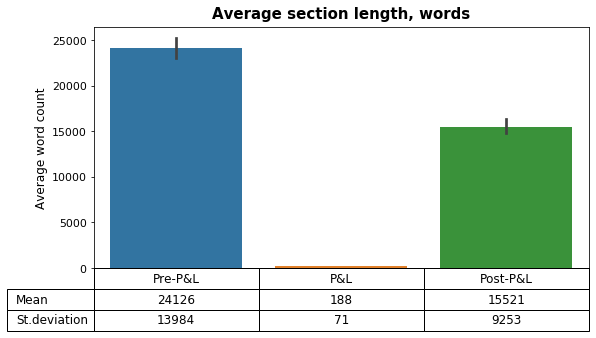

In [21]:
# plot the results
fig, ax = plt.subplots(figsize=(8, 4))
plt.subplots_adjust(bottom=0.4)
sns.barplot(x='label', y='count', data=df_counts, ax=ax)
ax.set_title('Average section length, words', fontsize=15, fontweight='bold', y=1.01)
ax.set_ylabel('Average word count', fontsize=12)
ax.tick_params(labelsize=11)
ax.get_xaxis().set_visible(False)
table = ax.table(cellText=stats, rowLabels=['Mean', 'St.deviation'], colLabels=['Pre-P&L', 'P&L', 'Post-P&L'], 
         cellLoc='center')
table.set(fontsize=12)
plt.tight_layout();

As we can see, P&L section (label=2) is by far the smallest section, with average length of ~190 words (standard deviation ~70).

## Split word lists into individual words

With word lists cleaned up, we're finally ready to reformat the data into a more granular, word-level view that we'll be using for training. To do that, I will define a method that takes a Pandas DataFrame and "stretches" a given column by converting lists of values into individual values as separate rows:

In [22]:
def flatten_data(data):
    return pd.Series([item for sublist in data for item in sublist])

In [23]:
def stretch_df_by_column(df, column):
    '''Converts lists contained in a given DataFrame column into separate rows.'''
    
    # identify columns that have to be replicated when a given column is "stretched"
    data = df.copy()
    cols_to_stretch = set(data.columns) - {column}
    data['len'] = data[column].apply(len)
    
    # convert values in those columns into lists
    for col in cols_to_stretch:
        data[col] = data.apply(lambda x: [x[col]] * x.len, axis=1)
    data.drop(columns=['len'], inplace=True)
    
    # create a new, "stretched" DataFrame
    df_new = pd.DataFrame()
    for col in df.columns:
        df_new[col] = flatten_data(data[col])
        
    return df_new

In [24]:
# "Stretch" the dataframe
ds = stretch_df_by_column(long, 'words')
ds.head()

,dir,train,words,label
0,12 Retech Corp,True,10-k,1
1,12 Retech Corp,True,<number>,1
2,12 Retech Corp,True,form10-k.htm,1
3,12 Retech Corp,True,united,1
4,12 Retech Corp,True,states,1


## Save pre-processed data

Finally, I'll save the resulting dataset in a file to be picked up in later phases of this project:

In [25]:
# Save resulting data into a file for future re-use
np.savez('files/data.npz', company=ds.dir.values, train=ds.train.values, labels=ds.label.values, words=ds.words.values)